# P5. Cross-Platform Reporting with Power BI & Spark

## Task 1: Set up BI Environment

In [52]:
from pyspark.sql import SparkSession

# Path to your SQLite JDBC driver
jdbc_jar_path = "/Users/katehuntsman/Documents/Business Intelligence/smart-store-huntsman/lib/sqlite-jdbc-3.49.0.0.jar"

# Create Spark session
spark = SparkSession.builder \
    .appName("SmartSalesAnalysis") \
    .config("spark.jars", jdbc_jar_path) \
    .getOrCreate()

## Task 2: Connect to Your Data Warehouse (PySpark to SQLite)

In [53]:
jdbc_url = "jdbc:sqlite:/Users/katehuntsman/Documents/Business Intelligence/smart-store-huntsman/dw/smart_sales.sqlite"

df_customers = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "customers") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_products = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "products") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sales = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "sales") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

# Preview the Data
df_customers.show(5)
df_products.show(5)
df_sales.show(5)

+-----------+-------------+-------+--------+-------------+---------------+
|customer_id|         Name| Region|JoinDate|LoyaltyPoints|CustomerSegment|
+-----------+-------------+-------+--------+-------------+---------------+
|       1000| Robert Gomez|   West| 2/25/24|         1200|        Regular|
|       1001|   John Silva|   East| 12/1/20|          850|        Premium|
|       1002|Mark Marshall|Central|  8/8/20|         5000|      Wholesale|
|       1003|David Brennan|  North| 5/21/20|          310|     OnlineOnly|
|       1004|Kerry Collins|  North| 9/12/23|         2750|        Regular|
+-----------+-------------+-------+--------+-------------+---------------+
only showing top 5 rows
+----------+--------------------+-----------+------+--------------+
|product_id|        product_name|   category| price|stock_quantity|
+----------+--------------------+-----------+------+--------------+
|      2000|      Electronics-Be|Electronics|969.31|           350|
|      2001|      Electronics

## Task 3: Query and Aggregate Data

In [54]:
# 1. Register tables as temporary views for SQL
df_sales.createOrReplaceTempView("sales")
df_customers.createOrReplaceTempView("customers")
df_products.createOrReplaceTempView("products")

# 2. SQL query to get total revenue per customer using correct column names
df_top_customers = spark.sql("""
    SELECT c.Name AS customer_name, SUM(s.sale_amount) AS total_spent
    FROM sales s
    JOIN customers c ON s.customer_id = c.customer_id
    GROUP BY c.Name
    ORDER BY total_spent DESC
""")

# 3. Show the result
df_top_customers.show()

# 4. Convert to pandas DataFrame for further visualization if needed
df_top_customers_pd = df_top_customers.toPandas()


+------------------+------------------+
|     customer_name|       total_spent|
+------------------+------------------+
|Stephanie Garrison|          23908.63|
|   Marvin Hamilton|          22913.52|
|     David Brennan|22362.350000000002|
|    William Palmer|20638.080000000005|
|      Jessica Mora|20346.670000000002|
|         Cheryl Wu|          20243.14|
|Christopher Dodson|19539.610000000004|
|     Emily Hoffman|          18566.22|
|     Glenn Shelton|          18344.22|
|        Mark Gomez|          17970.34|
|    Jordan Elliott|          17858.39|
|     Dustin Medina|          17852.59|
|     Kerry Collins|17451.920000000002|
|    Kenneth Graves|          17223.81|
|       Ashley Todd|           17208.6|
|      Paul Perkins|          17080.21|
|      James Cooley|          17011.76|
|        Nancy King|16932.309999999998|
|   William Benitez|          16384.08|
|       Ryan Martin|16152.890000000001|
+------------------+------------------+
only showing top 20 rows


## Task 4: Slice, Dice, and Drill Down

In [55]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType
from datetime import datetime

# Step 1: Filter sales from 2023 onward (string comparison is fine for ISO dates)
df_filtered = df_sales.filter(df_sales.sale_date >= "2023-01-01")
df_filtered.show(5)

# Step 2: Create temp views for SQL joins
df_filtered.createOrReplaceTempView("sales")  # Use filtered sales only
df_customers.createOrReplaceTempView("customers")
df_products.createOrReplaceTempView("product")

# Step 3: Dicing - Group sales by product category & region
df_sales_products = spark.sql("""
    SELECT p.category AS product_category, c.Region, SUM(s.sale_amount) AS total_sales
    FROM sales s
    JOIN customers c ON s.customer_id = c.customer_id
    JOIN product p ON s.product_id = p.product_id
    GROUP BY p.category, c.Region
    ORDER BY total_sales DESC
""")
df_sales_products.show()

# Step 4: Drilldown - Aggregate sales by year → quarter → month with safe date parsing

# Define safe date parsing UDF (returns None if invalid)
def safe_parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

safe_parse_date_udf = udf(safe_parse_date, DateType())

# Apply UDF on filtered sales to create parsed date column
df_filtered_date = df_filtered.withColumn("sale_date_parsed", safe_parse_date_udf("sale_date"))

# Filter out invalid dates (where parsing failed)
df_sales_valid = df_filtered_date.filter(df_filtered_date.sale_date_parsed.isNotNull())

# Create temp view for valid sales data
df_sales_valid.createOrReplaceTempView("sales_date_valid")

# SQL aggregation drilldown
df_drilldown = spark.sql("""
    SELECT
        YEAR(sale_date_parsed) AS year,
        QUARTER(sale_date_parsed) AS quarter,
        MONTH(sale_date_parsed) AS month,
        SUM(sale_amount) AS total_sales
    FROM sales_date_valid
    GROUP BY year, quarter, month
    ORDER BY year, quarter, month
""")

df_drilldown.show()


+--------------+----------+-----------+----------+--------+-----------+-----------+----------------+------------+
|transaction_id| sale_date|customer_id|product_id|store_id|campaign_id|sale_amount|discount_percent|payment_type|
+--------------+----------+-----------+----------+--------+-----------+-----------+----------------+------------+
|             1|2025-05-04|       1034|      2059|     402|          0|     2048.2|            10.0|  CreditCard|
|             2|2025-05-04|       1066|      2048|     403|          1|     321.87|             0.0|      PayPal|
|             3|2025-05-04|       1116|      2041|     403|          3|    3216.84|             5.5|        Cash|
|             4|2025-05-04|       1071|      2096|     404|          2|    1613.23|            20.0|BankTransfer|
|             5|2025-05-04|       1020|      2060|     401|          0|     408.38|            15.0|  CreditCard|
+--------------+----------+-----------+----------+--------+-----------+-----------+-----

## Task 5: Create Interactive Visualizations (Seaborn + Matplotlib)

/var/folders/lr/4whsggrn38sckt88gcfvgqmr0000gn/T/ipykernel_96982/1750418157.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_customers_pd, x="customer_name", y="total_spent",


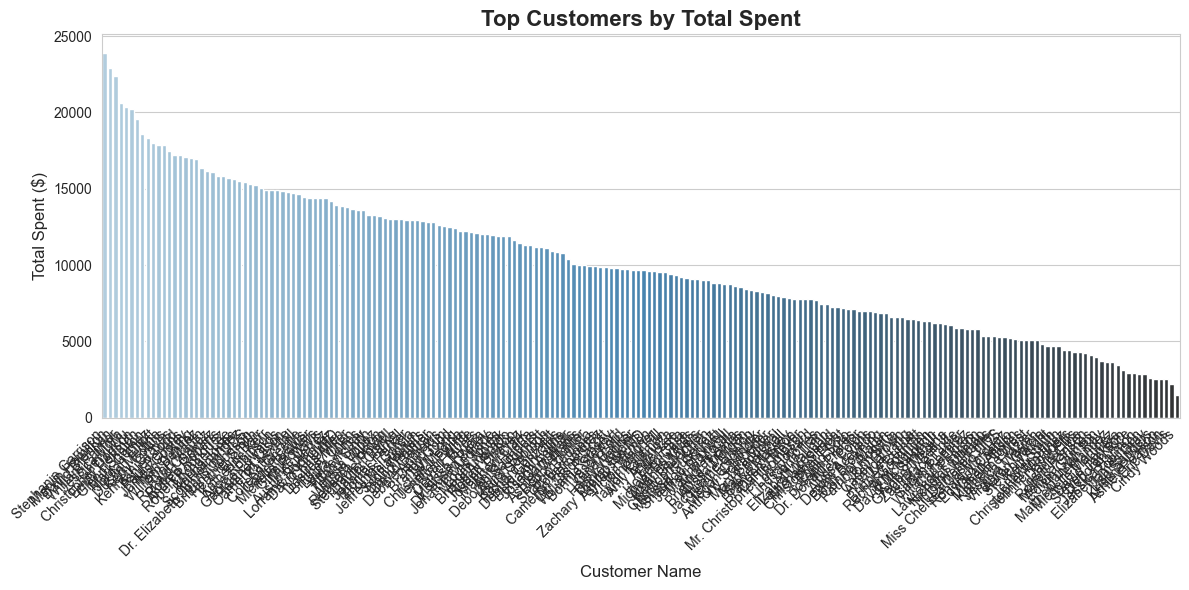

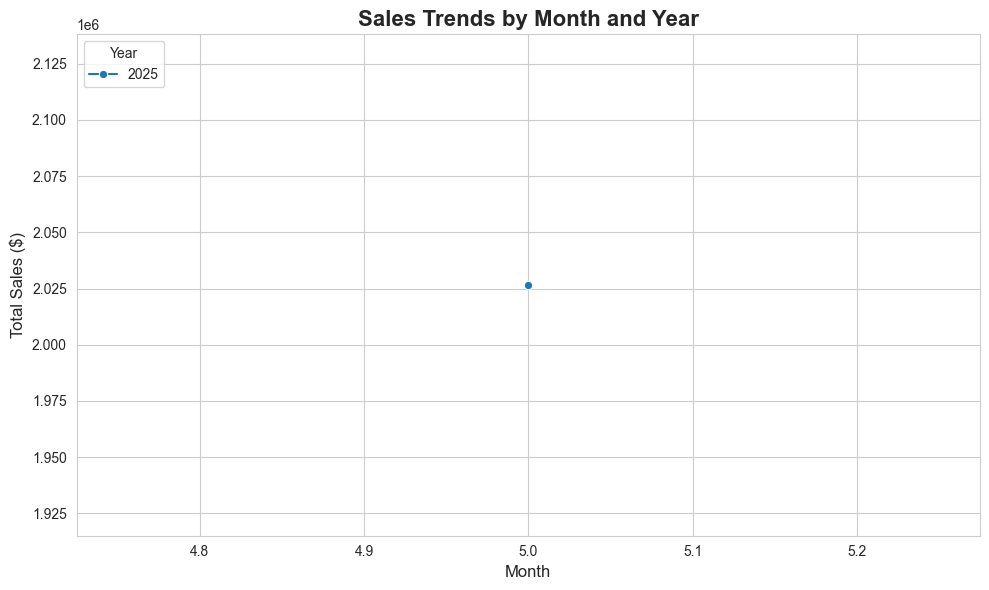

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a clean style for all plots
sns.set_style("whitegrid")

# Bar chart for Top Customers
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_customers_pd, x="customer_name", y="total_spent",
            palette="Blues_d")  # nice blue gradient palette
plt.xticks(rotation=45, ha='right')  # rotate labels, align right for readability
plt.xlabel("Customer Name", fontsize=12)
plt.ylabel("Total Spent ($)", fontsize=12)
plt.title("Top Customers by Total Spent", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Line chart for Sales Trends
df_drilldown_pd = df_drilldown.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_drilldown_pd, x="month", y="total_sales", hue="year",
             marker="o", palette="tab10")  # distinct colors for years
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.title("Sales Trends by Month and Year", fontsize=16, weight='bold')
plt.legend(title='Year', loc='upper left')
plt.tight_layout()
plt.show()

